In [1]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from functools import partial

np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

Init Plugin
Init Graph Optimizer
Init Kernel


# Lab 1: Tackling Fashion MNIST With a CNN
## Load data

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

## Build Model

In [3]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation="relu", padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax')
])

Metal device set to: Apple M1


2021-08-03 11:36:49.897846: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-08-03 11:36:49.898201: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Training

In [4]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

2021-08-03 11:36:51.358648: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-03 11:36:51.361447: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10


2021-08-03 11:36:51.853310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 499/1719 [=======>......................] - ETA: 45s - loss: 1.0668 - accuracy: 0.6209

KeyboardInterrupt: 

# Lab 2: Using a Pretrained Model
## Download data and model weight

* We will use a Resnet 50 model, pretrained on ImageNet dataset to predict 2 images (e.g., china,jpg and flower jpg)

In [ ]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

## Resize data

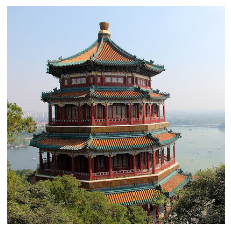

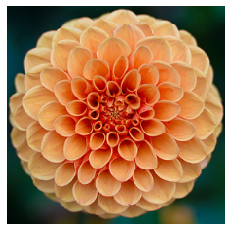

In [ ]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
image_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(image_resized[0])
plt.show()
plot_color_image(image_resized[1])
plt.show()

## Make a prediction (top_K code is provided)

In [6]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

NameError: name 'images_resized' is not defined

In [ ]:
Y_proba.shape

In [ ]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

# Lab 3: Pretrained Models for Transfer Learning
## Data Preparation

In [ ]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

In [ ]:
class_names = info.features["label"].names
class_names

In [ ]:
n_classes = info.features["label"].num_classes
n_classes

In [ ]:
dataset_size = info.splits["train"].num_examples
dataset_size

In [ ]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

## Some data samples

In [ ]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

## Preprocess data

In [ ]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

## Build a model that uses pretrained Xception as base model

In [ ]:
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [ ]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

## Fine-tuning (freeze base model)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set, validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=10)

In [ ]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set, validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=10)

# 연습문제(Exercise)

## Question 1
Build a CNN model to classify fashion mnist dataset.

* np.random.seed(42)와 tf.random.set_seed(42) 반드시 42로 설정해야합니다.

**Model architecture**
 * Input layer
 * Conv(filters=64,kernel_size=3)
 * Conv(filters=64,kernel_size=3)
 * MaxPooling(pool_size=2)
 * Conv(filters=128,kernel_size=3)
 * Conv(filters=128,kernel_size=3)
 * MaxPooling(pool_size=2)
 * Conv(filters=256,kernel_size=3)
 * Conv(filters=256,kernel_size=3)
 * Conv(filters=256,kernel_size=3)
 * MaxPooling(pool_size=2)
 * Flatten()
 * Dense(128)
 * Output layer

Train the model with a proper optimizer and learning rate for 10 epochs.  Report accuracy on test set.


정답은 Test의 정확도가 0.9보다 크거나 같아야합니다.


### 1. 데이터 로드
### 1.1 패션 MNIST 데이터 로드하시오.

### 1.2 학습 데이터로 검증(vaild) 데이터 만들시오.
* 인덱스 번호 기준 -50000번 입니다.

### 1.3 표준화(Standard Scale) 시키시오.

### 1.4 이미지 shape을 (28,28) -> (28,28,1)로 변환하시오.

### 2. 모델 빌드
### 2.1 모델 구축하시오.

### 2.2 모델 loss 및 opimizer 설정하시오.
* metrics 는 정확도로 설정하시오.

### 2.3 학습

### 3. 성능 평가하시오.
* 정답은 Test의 정확도가 0.9보다 크거나 같아야합니다.

## Question 2
 For the task in lab 3, use InceptionV3 (pretrained on ImageNet) as base model and train the model again. Report accuracy on test set.
* np.random.seed(42)와 tf.random.set_seed(42) 반드시 42로 설정해야한다.


정답은 Test의 정확도가 0.9보다 크거나 같아야합니다.